# Implementation of a Timeline Axis in Directly Follows Graph in PM4Py

Process mining exploits Event Logs to generate knowledge of a process.
A wide variety of information systems, e.g., SAP, ORACLE, SalesForce, etc., allow us to extract, in one way or the other,
event logs similar to the example event logs. 

Data Visualisation is a very effective method to comprehend and analyse data and information in an easier manner. Visual elements, such as graphs, make it easier to see the trends and patterns in data. Process Mining concerns itself with gathering information from the event logs and using it to extract process-related information using various algorithms such as alpha miner, heuristics miner, fuzzy miner, and inductive miner. The output is shown in a visual manner in the form of a graph, a Petri net, or a BPMN diagram. One such graph is the Directly Follows Graph which shows the order of the events from the event log. This thesis concerns itself with the implementation of a visual timeline axis in the Directly Follows Graph in the programming language Python, as part of the library Process Mining for Python (PM4Py). Such visualisation of the timeline axis in the Directly Follows Graph will enable a quick understanding of how long, on average, an event takes to be executed in a business process.

This tutorial, we will use a sample date of a loan application process to guide the implementation of the timeline axis.

**Note:** before running the notebook, make sure [Graphviz](https://graphviz.org/) is installed on your machine, e.g., by running `brew install graphviz` (macOS with homebrew). Also, make sure you have actually installed the pm4py version that is provided in this exact repository, on this exact branch (e.g.: `pip install -e .`).

In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

import pm4py

### Step 1: Import XES Event Data 

We read the XES event log file that gets converted to a pandas Dataframe. This dataframe has columns 'time:timestamp' for the timestamps of each event,  'concept:name' for each activity that gets executed, and 'case:concept:name' as the trace ID.  

In [3]:
file1 = "notebooks/data/Artificial - Loan Process.xes"
log = pm4py.read_xes(file1)
log.head(6)

parsing log, completed traces ::   0%|          | 0/100 [00:00<?, ?it/s]

,time:timestamp,concept:name,lifecycle:transition,case:concept:name
0,2013-04-16 08:08:01.821000+00:00,register application,complete,trace 0
1,2013-04-16 08:16:02.889000+00:00,check credit,complete,trace 0
2,2013-04-16 08:16:27.858000+00:00,calculate capacity,complete,trace 0
3,2013-04-16 08:20:25.117000+00:00,check system,complete,trace 0
4,2013-04-16 08:21:29.939000+00:00,accept,complete,trace 0
5,2013-04-16 08:26:53.166000+00:00,send decision e-mail,complete,trace 0


### Step 2: Discovering the DFG

Each process model has various algorithmic variants. DFG has the following variants 
1. Case attributes
2. clean polars
3. clean
4. freq_triples
5. native
6. performance 

discover_dfg_typed applied the clean variant of DFG. The clean variant also uses the freq_triples. freq_triples calculate the frequency or the occurance of each directly-follows relation in the event log. For instance, if there has been 6 records of an activity b occuring after activity a, then frequency from a to b is 6. 

Discover_dfg_typed returns a triple. The first element is that gets returned is a DFG object. This object is in the form of ((a, b): f). It is a dictionary mapping the directly-follows relation to the frequency. The other two objects that get returned are the start and the end activities of a DFG. 

In [4]:
dfg, start_act, end_act = pm4py.discover_dfg_typed(log) 
print(dfg)

{('accept', 'send decision e-mail'): 20, ('calculate capacity', 'accept'): 13, ('calculate capacity', 'check credit'): 6, ('calculate capacity', 'check system'): 46, ('calculate capacity', 'reject'): 35, ('check credit', 'accept'): 1, ('check credit', 'calculate capacity'): 54, ('check credit', 'check system'): 38, ('check credit', 'reject'): 7, ('check system', 'accept'): 6, ('check system', 'calculate capacity'): 42, ('check system', 'check credit'): 4, ('check system', 'reject'): 38, ('register application', 'calculate capacity'): 4, ('register application', 'check credit'): 90, ('register application', 'check system'): 6, ('reject', 'send decision e-mail'): 80}


Another important variant is the performance variant. The performance variant returns the statistical temporal information about the events in the process such as the mean, medium, maximum time. However, since we are interested in comparing the value of an activity with the start event, the temporal information provided by dfg performance variant is redundant in the implementation of the timeline axis.

In [5]:
dfg_perf, start_act, end_act = pm4py.discover_performance_dfg(log)
dfg_perf 
list(dfg_perf.keys())[0]    # key of "first" element
list(dfg_perf.values())[0]  # value of "first" element
list(dfg_perf.items())[0]   # (key, value) tuple of "first" element

(('accept', 'send decision e-mail'),
 {'mean': 243.7,
  'median': 228.0,
  'max': 491.0,
  'min': 43.0,
  'sum': 4874.0,
  'stdev': 138.87142861010156})

We have introduced another algorithmic variant of the dfg, called <b> clean_timeline </b>. Clean_timeline vairant incorporates the clean variant with frequency and additionally adds statistics on relative time for each trace based on the start activity. 

Example: We have six acitivities in trace 0 for the loan application process. We know that the start activity is 'register application' from discover_dfg_typed. Let us say that the start activity gets a timestamp of 00:00:00 because it has a time difference of 0 hours, 0 minutes, and 0 seconds from the start activity. Similarily, we calculate the absolute time of each activity relative to the start activity of thattrace. In other words, how much time has elapsed since the beginning of the process until a particular event takes place. 

In [6]:
dfg_time = pm4py.discover_timeline_dfg(log)

start discover_timeline_dfg
finish getting parameters
start clean_time
dict_keys(['register application', 'check credit', 'calculate capacity', 'check system', 'accept', 'send decision e-mail', 'reject'])
register application
-1 days +23:59:59.999999995

check credit
0 days 00:06:07.102099988

calculate capacity
0 days 00:12:00.540670003

check system
0 days 00:11:52.301911108

accept
0 days 00:18:54.453750009

send decision e-mail
0 days 00:24:14.436590018

reject
0 days 00:19:20.913925012

{'register application': Timedelta('-1 days +23:59:59.999999995'), 'check credit': Timedelta('0 days 00:06:07.102099988'), 'calculate capacity': Timedelta('0 days 00:12:00.540670003'), 'check system': Timedelta('0 days 00:11:52.301911108'), 'accept': Timedelta('0 days 00:18:54.453750009'), 'send decision e-mail': Timedelta('0 days 00:24:14.436590018'), 'reject': Timedelta('0 days 00:19:20.913925012')}


For each trace, we calculate the time elapsed relative to the timestamp of that particular case's start activity. Once that is done, we calculate the average of all the activities having the same concept:name.

Example: let us say, we have an event log having only two traces. Each trace has a sequence of activities a, b, c. 'a' is the start activity. In our discover_timeline_dfg, we calculate the relative time of each activity according to the trace. The time elapsed for the activity 'b' in trace 1 is 8 minutes and in trace 2 is 9 minutes.  

We calculate the average time elapsed for the activity 'b' through the formula : 

(b time elapsed in trace 1 + b time elapsed in trace 2 ) / 2 

= (8 + 9) / 2 
= 17 / 2
= 8.5 minutes 

<b>discover_timeline_dfg </b> returns a dictionary object mapping each activity to its average time elapsed. The type of the value in the dictionary is Timedelta.   

In [7]:
dfg_time

{'register application': Timedelta('-1 days +23:59:59.999999995'),
 'check credit': Timedelta('0 days 00:06:07.102099988'),
 'calculate capacity': Timedelta('0 days 00:12:00.540670003'),
 'check system': Timedelta('0 days 00:11:52.301911108'),
 'accept': Timedelta('0 days 00:18:54.453750009'),
 'send decision e-mail': Timedelta('0 days 00:24:14.436590018'),
 'reject': Timedelta('0 days 00:19:20.913925012')}

### Step 3: Visualisation 

The visualisation API of pm4py includes many visualisation functions like view_performance_dfg, view_dfg_typed, view_petri_net and so on. Similar to the algorithmic variants for each discovery algorithm, each process model also has visualisation variants. The DFG visualiser has the variants frequency and performance. The frequency variant is responsible for showing the frequency of directly-follows activities on the graph while the performance variant shows the temporal profile of the graph. Below you can see the result of a performance variant visualiser and a frequency variant visualiser. 

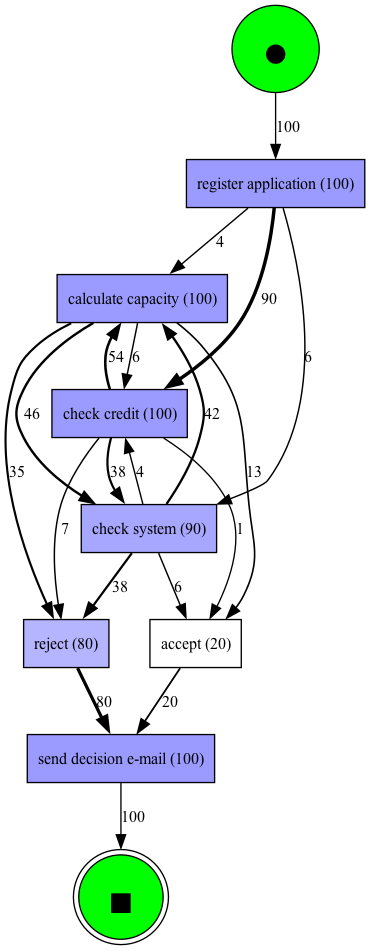

In [8]:
pm4py.view_dfg(dfg, start_act, end_act)

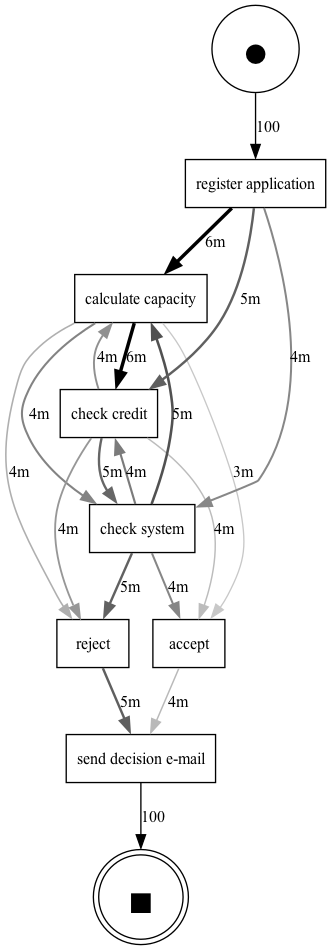

In [9]:
pm4py.view_performance_dfg(dfg_perf, start_act, end_act)

We introduct a new dfg visualiser variant called <b> view_timeline_dfg </b>. It takes four parameters: the dfg object, start activity, end activity, and the dfg time dictionary. There are some default parameters set for the visualisation such as backgroud colour and font size of the text on the output image, type of output image. 

The following steps are taken for the visualisation 
1. Set the default parameters for the visualisation unless otherwise specified 
    
    1.1. Background colour = white
    
    1.2. font size = 12
    
    1.3. image format = png
   
  
2. Get the information of the directly-follows relationship. This information is passed as a parameter as a DFG-object that we created. 


3. Create a Graphviz object programmatically having the desired layout engine and the desired layout 


Graph visualization is a way of representing structural information as diagrams of abstract graphs and networks. 

A DFG is a directed graph in which the nodes are annotated with either an activity, start or end \cite(leeman's Directly Follows-Based Process Mining: Exploration & a Case Study). 

Graphviz has several layout programs. \cite(https://graphviz.org/about/). Few of the graph layouts are shown here https://graphviz.org/gallery/ (colour wheel, neato layout ). These layout programs take descriptions of graphs in a simple text language, and make diagrams in several useful formats such as images and SVG for web pages. 

Graphviz uses the DOT language which is an abstract grammar used to define nodes, edges, graphs, subgraphs, and clusters. 
There exist various algorithms for projecting abstract graphs into a space for visualization. These algorithms are known as the layout engine. Graphviz has many layout engines that need to be declared while writing the grammar for the graph in the DOT language. Some of the layout engines are mentioned below: 

- dot : This layout engine is responsible for painting hierarchical or layered drawing. In a layered graph drawing, the vertices of the graph are drawn in horizontal rows or layers with the edges generally directed downwards.
- neato : This layout engine is responsible for a spring layout.
- circo : This layout engine is responsible for painting the graph elements in a circular manner i.e.  it places the vertices of a graph on a circle, often evenly spaced so that they form the vertices of a regular polygon. 


Since a DFG is essentially showing the hierarchy and is a directed graph \cite{leeman}, we use the layout engine 'dot' for our implementation.


('register application', Timedelta('-1 days +23:59:59.999999995'))
-1e-06
register application -1 days +23:59:59.999999995  ----- >  0s
('check credit', Timedelta('0 days 00:06:07.102099988'))
367.102099
check credit 0 days 00:06:07.102099988  ----- >  6m
('check system', Timedelta('0 days 00:11:52.301911108'))
712.301911
check system 0 days 00:11:52.301911108  ----- >  11m
('calculate capacity', Timedelta('0 days 00:12:00.540670003'))
720.54067
calculate capacity 0 days 00:12:00.540670003  ----- >  12m
('accept', Timedelta('0 days 00:18:54.453750009'))
1134.45375
accept 0 days 00:18:54.453750009  ----- >  18m
('reject', Timedelta('0 days 00:19:20.913925012'))
1160.913925
reject 0 days 00:19:20.913925012  ----- >  19m
('send decision e-mail', Timedelta('0 days 00:24:14.436590018'))
1454.43659
send decision e-mail 0 days 00:24:14.436590018  ----- >  24m
{'register application': '-8059494152491491220', 'check credit': '8588844872758652964', 'check system': '-2956287484800029273', 'calcul

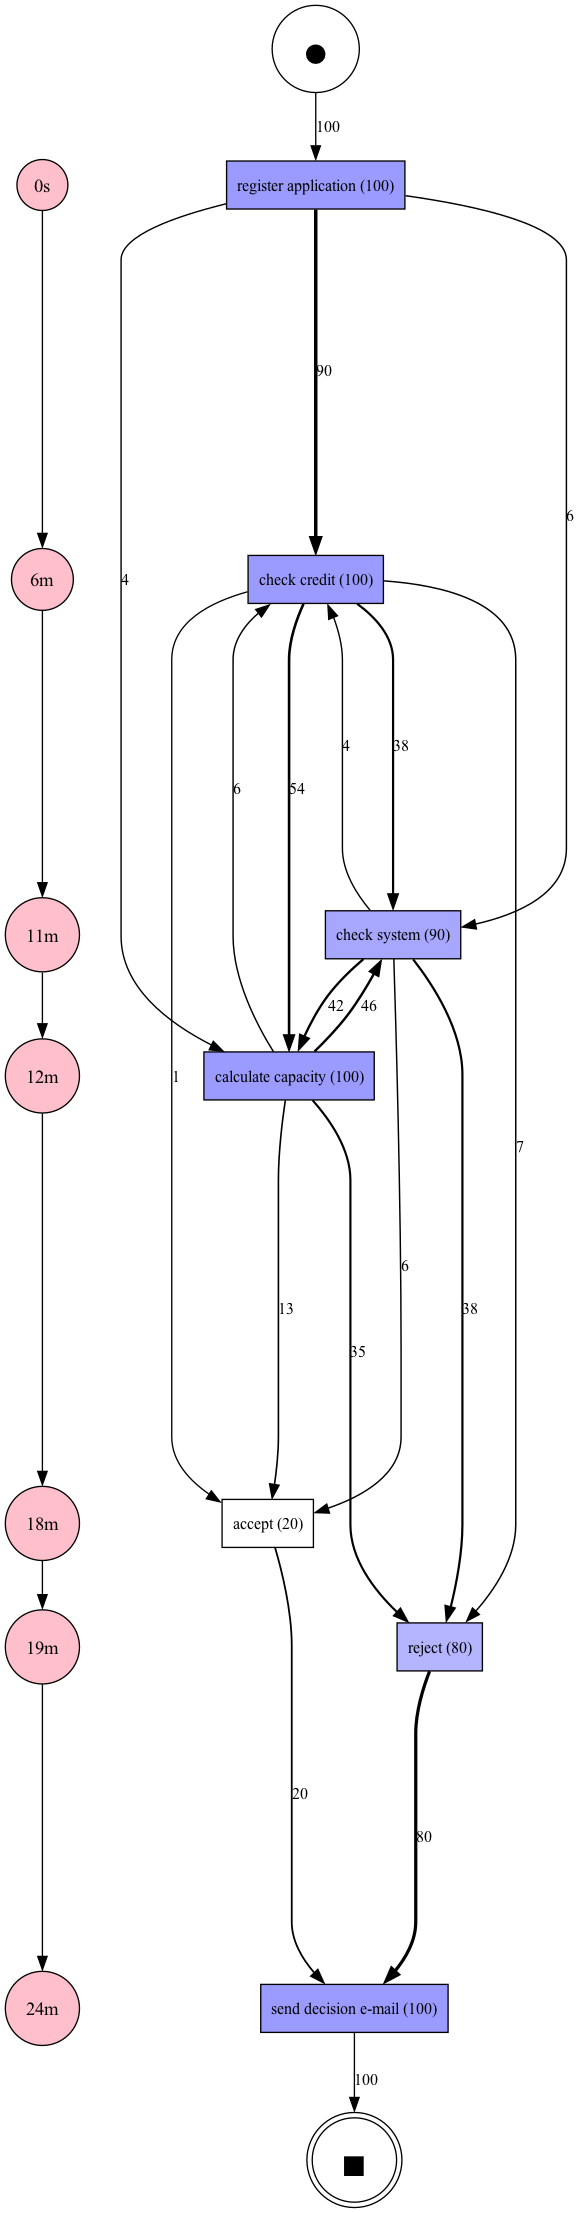

In [10]:
pm4py.view_timeline_dfg(dfg, start_act, end_act, dfg_time) 